In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.max_rows = 10

/Users/kylemix/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [133]:
df = pd.read_csv('2013_movies.csv')

### First,  we'll normalize the data by creating z-scores for continuous variables and dummies for categorical ones, and finally dropping anything that we can't easily model


In [134]:
df.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
0,The Hunger Games: Catching Fire,130000000,424668047,Francis Lawrence,PG-13,146,11/22/13 0:00
1,Iron Man 3,200000000,409013994,Shane Black,PG-13,129,5/3/13 0:00
2,Frozen,150000000,400738009,Chris BuckJennifer Lee,PG,108,11/22/13 0:00
3,Despicable Me 2,76000000,368061265,Pierre CoffinChris Renaud,PG,98,7/3/13 0:00
4,Man of Steel,225000000,291045518,Zack Snyder,PG-13,143,6/14/13 0:00


In [135]:
# convert to datetime,  add column for release quarter
df['ReleaseDate'] = pd.to_datetime(df.ReleaseDate,infer_datetime_format=True)
df['ReleaseQuarter'] = df.ReleaseDate.dt.quarter

In [136]:
# pull constant variable columns
df_z = df[['Budget', 'DomesticTotalGross', 'Runtime']]

In [137]:
# generate z-scores for selected cols
cols = list(df_z.columns)
for col in cols:
    col_zscore = col + '_zscore'
    df_z[col_zscore] = (df_z[col] - df_z[col].mean())/df_z[col].std(ddof=0)

/Users/kylemix/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [138]:
ratings = pd.get_dummies(df.Rating)

In [268]:
quarters = pd.get_dummies(df.ReleaseQuarter, prefix='Q')

In [140]:
dfz = pd.concat([df_z[['Budget_zscore','DomesticTotalGross_zscore','Runtime_zscore']], ratings, quarters], axis=1)

In [269]:
quarters.head()

,Q_1,Q_2,Q_3,Q_4
0,0,0,0,1
1,0,1,0,0
2,0,0,0,1
3,0,0,1,0
4,0,1,0,0


# exercise 3.1
### Predict using a column of ones

In [142]:
y = dfz.DomesticTotalGross_zscore
X1 = np.ones([len(y),1],dtype=np.int8)
mod1 = sm.OLS(y,X1)
fit1 = mod1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                      -0.000
Model:                                   OLS   Adj. R-squared:                 -0.000
Method:                        Least Squares   F-statistic:                      -inf
Date:                       Thu, 13 Oct 2016   Prob (F-statistic):                nan
Time:                               23:01:55   Log-Likelihood:                -141.89
No. Observations:                        100   AIC:                             285.8
Df Residuals:                             99   BIC:                             288.4
Df Model:                                  0                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       2.082e-17      0.101   2.07e-16      1.000        -0.199     0.199
==============================================================================
Omnibus:                       51.114   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.961
Skew:                           1.985   Prob(JB):                     4.45e-28
Kurtosis:                       6.804   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
y_pred1 = fit1.predict(X1)

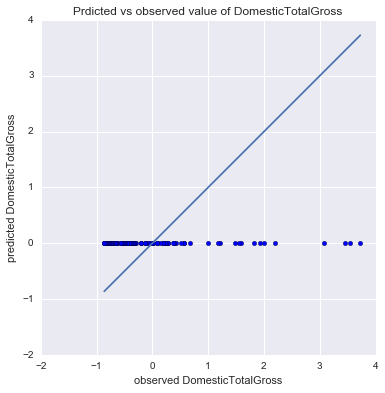

In [144]:
plt.figure(figsize=(6,6))
plt.scatter(y, y_pred1)
plt.title('Prdicted vs observed value of DomesticTotalGross')
plt.xlabel('observed DomesticTotalGross')
plt.ylabel('predicted DomesticTotalGross')
plt.plot(y,y);

##### given a column of ones as a feature,  the predicted value of DomesticTotalGross of every movie in the dataset is the same.  This value is equal to the intercept.

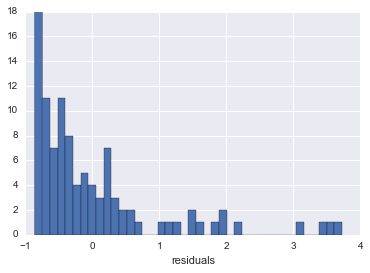

In [145]:
residuals = y - y_pred1
plt.hist(residuals, bins = 40)
plt.xlabel('residuals');

#####  this plot shows a strong skew to the right.  due to the very low coefficient, this is effectively a distribution of the z-scores of domesticTotalGross,  as you can see below

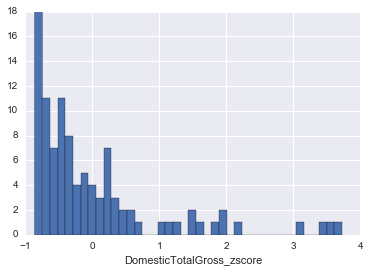

In [146]:
plt.hist(dfz.DomesticTotalGross_zscore, bins = 40)
plt.xlabel('DomesticTotalGross_zscore');

# Exercise 3.2

In [147]:
y = dfz.DomesticTotalGross_zscore
X2 = pd.concat([dfz.Runtime_zscore, pd.DataFrame(np.ones([len(y),1]), columns=['ones'])], axis=1)
model2 = sm.OLS(y,X2)
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                       0.086
Model:                                   OLS   Adj. R-squared:                  0.076
Method:                        Least Squares   F-statistic:                     9.180
Date:                       Thu, 13 Oct 2016   Prob (F-statistic):            0.00313
Time:                               23:01:58   Log-Likelihood:                -137.42
No. Observations:                        100   AIC:                             278.8
Df Residuals:                             98   BIC:                             284.0
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Runtime_zscore     0.2927      0.097      3.030      0.003         0.101     0.484
ones            9.368e-17      0.097    9.7e-16      1.000        -0.192     0.192
==============================================================================
Omnibus:                       50.222   Durbin-Watson:                   0.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.001
Skew:                           1.932   Prob(JB):                     7.19e-28
Kurtosis:                       6.883   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Our R2 improved,  not by much,  but it shows we are beginning to predict something.  the coefficient for runtime confirms this

In [148]:
y_pred2 = fit.predict(X2)

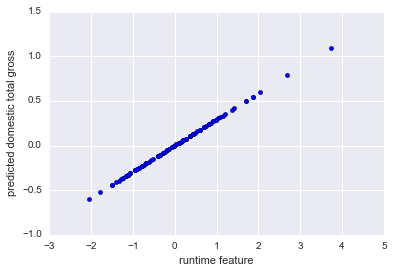

In [150]:
plt.scatter(X2.iloc[:,0],y_pred2)
plt.xlabel('runtime feature')

plt.ylabel('predicted domestic total gross');

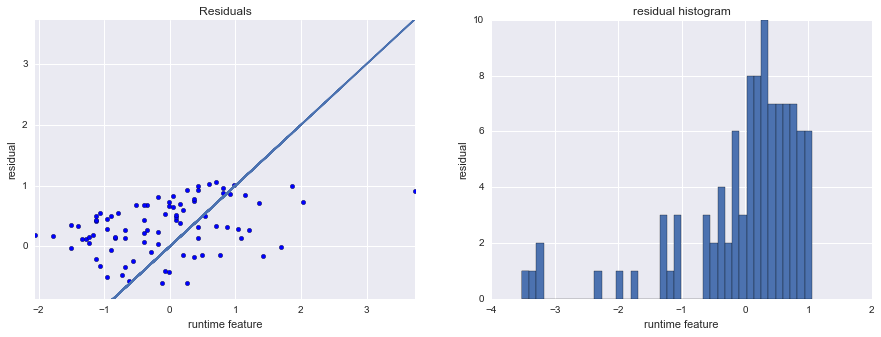

In [151]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X2.iloc[:,0], y_pred2-y)
plt.plot(X2.iloc[:,0],X2.iloc[:,0])
plt.title('Residuals')
plt.xlabel('runtime feature')
plt.ylabel('residual')
plt.xlim(min(X2.iloc[:,0]), max(X2.iloc[:,0]))
plt.ylim(min(y), max(y));

plt.subplot(1,2,2)
plt.hist(y_pred2-y, bins = 40)
plt.xlabel('runtime feature')
plt.ylabel('residual')
plt.title('residual histogram');

##### We can see that our model is beginning to preform,  the histogram shows that we are beginning to approach a normal distribution, though clearly we still have a ways to go.  the residuals will represent random noise in our dataset, and so when we see a nice clean normal distribution,  we can be confident that we are effectively fitting

# Exercise 3.3

###### as a categorical variable I'll use rating which I converted earlier

In [152]:
y = dfz.DomesticTotalGross_zscore
X3 = pd.concat([X2, ratings], axis=1)
mod3 = sm.OLS(y,X)
fit3 = mod3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                       0.215
Model:                                   OLS   Adj. R-squared:                  0.182
Method:                        Least Squares   F-statistic:                     6.497
Date:                       Thu, 13 Oct 2016   Prob (F-statistic):           0.000115
Time:                               23:02:41   Log-Likelihood:                -129.80
No. Observations:                        100   AIC:                             269.6
Df Residuals:                             95   BIC:                             282.6
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Runtime_zscore     0.3449      0.097      3.574      0.001         0.153     0.537
ones               0.4636      0.193      2.407      0.018         0.081     0.846
G                  1.5674      0.730      2.147      0.034         0.118     3.017
PG                 0.1225      0.269      0.455      0.650        -0.412     0.657
PG-13             -0.4388      0.222     -1.978      0.051        -0.879     0.002
R                 -0.7875      0.224     -3.511      0.001        -1.233    -0.342
==============================================================================
Omnibus:                       43.608   Durbin-Watson:                   0.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.295
Skew:                           1.721   Prob(JB):                     2.03e-21
Kurtosis:                       6.319   Cond. No.                     1.25e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.99e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [153]:
X3

,Runtime_zscore,ones,G,PG,PG-13,R
0,1.864138,1,0,0,1,0
1,0.924887,1,0,0,1,0
2,-0.235365,1,0,1,0,0
3,-0.787866,1,0,1,0,0
4,1.698388,1,0,0,1,0
...,...,...,...,...,...,...
95,0.593386,1,0,0,0,1
96,0.703886,1,0,0,1,0
97,-0.180115,1,0,0,0,1
98,-1.064117,1,0,0,0,1


In [154]:
y_pred3 = fit3.predict(X3)
print(metrics.r2_score(y,y_pred3))

0.214804839881


###### Our r-squared jumped with the addition of the categorical variable rating,  this was to be expected given the nature of how ratings can affect the size of the market available to a given movie.  p-values showed signifigance for all but one rating,  PG,  this is also intuitive given that a parent who will let their child see a G movie will likely also let them see a PG movie,  future iterations will combine the G and PG rating into one category to see how that effects the p-value

# Exercise 3.4

In [155]:
ratings['kids'] = ratings.G + ratings.PG
ratings2 = ratings.drop(ratings[['G','PG']], axis=1)

In [156]:
ratings2.head()

,PG-13,R,kids
0,1,0,0
1,1,0,0
2,0,0,1
3,0,0,1
4,1,0,0


In [157]:
X4 = pd.concat([X2, ratings2],axis=1)
mod4 = sm.OLS(y,X4)
fit4 = mod4.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                       0.195
Model:                                   OLS   Adj. R-squared:                  0.170
Method:                        Least Squares   F-statistic:                     7.765
Date:                       Thu, 13 Oct 2016   Prob (F-statistic):           0.000107
Time:                               23:04:58   Log-Likelihood:                -131.03
No. Observations:                        100   AIC:                             270.1
Df Residuals:                             96   BIC:                             280.5
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Runtime_zscore     0.3509      0.097      3.613      0.000         0.158     0.544
ones               0.0950      0.077      1.234      0.220        -0.058     0.248
PG-13             -0.0720      0.127     -0.564      0.574        -0.325     0.181
R                 -0.4184      0.131     -3.196      0.002        -0.678    -0.159
kids               0.5853      0.187      3.138      0.002         0.215     0.956
==============================================================================
Omnibus:                       39.053   Durbin-Watson:                   0.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.018
Skew:                           1.600   Prob(JB):                     3.11e-17
Kurtosis:                       5.828   Cond. No.                     2.30e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.64e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

##### well that didn't work as expected, r2 dropped,  we'll try again,  and this time simply drop PG

In [275]:
ratings3 = ratings.drop(ratings[['kids']], axis=1)


In [162]:
X5 = pd.concat([X2, ratings3],axis=1)
mod5 = sm.OLS(y,X5)
fit5 = mod5.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                       0.215
Model:                                   OLS   Adj. R-squared:                  0.182
Method:                        Least Squares   F-statistic:                     6.497
Date:                       Thu, 13 Oct 2016   Prob (F-statistic):           0.000115
Time:                               23:08:06   Log-Likelihood:                -129.80
No. Observations:                        100   AIC:                             269.6
Df Residuals:                             95   BIC:                             282.6
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Runtime_zscore     0.3449      0.097      3.574      0.001         0.153     0.537
ones               0.5861      0.244      2.404      0.018         0.102     1.070
G                  1.4449      0.940      1.538      0.127        -0.421     3.310
PG-13             -0.5614      0.285     -1.967      0.052        -1.128     0.005
R                 -0.9100      0.284     -3.202      0.002        -1.474    -0.346
==============================================================================
Omnibus:                       43.608   Durbin-Watson:                   0.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.295
Skew:                           1.721   Prob(JB):                     2.03e-21
Kurtosis:                       6.319   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
y_pred5 = fit5.predict(X5)
print(metrics.r2_score(y,y_pred5))

0.214804839881


##### interesting, exactly the same performance,  we'll stick with a dropped PG column so that we're sure our P-Values are all good, and add our release quarter

In [188]:
X2.columns

Index(['Runtime_zscore', 'ones'], dtype='object')

In [184]:

X6 = pd.concat([X2, ratings3, quarters], axis=1)
mod6 = sm.OLS(y,X6)
fit6 = mod6.fit()
fit6.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                       0.248
Model:                                   OLS   Adj. R-squared:                  0.191
Method:                        Least Squares   F-statistic:                     4.344
Date:                       Thu, 13 Oct 2016   Prob (F-statistic):           0.000339
Time:                               23:33:03   Log-Likelihood:                -127.62
No. Observations:                        100   AIC:                             271.2
Df Residuals:                             92   BIC:                             292.1
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Runtime_zscore     0.3229      0.100      3.244      0.002         0.125     0.521
ones               0.5361      0.199      2.693      0.008         0.141     0.931
G                  1.0536      0.958      1.100      0.274        -0.849     2.957
PG-13             -0.6664      0.290     -2.299      0.024        -1.242    -0.091
R                 -0.9572      0.286     -3.350      0.001        -1.525    -0.390
1                  0.0334      0.185      0.180      0.857        -0.334     0.400
2                  0.4349      0.185      2.348      0.021         0.067     0.803
3                 -0.0938      0.151     -0.619      0.537        -0.395     0.207
4                  0.1616      0.159      1.020      0.311        -0.153     0.476
==============================================================================
Omnibus:                       42.429   Durbin-Watson:                   0.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.702
Skew:                           1.665   Prob(JB):                     7.41e-21
Kurtosis:                       6.340   Cond. No.                     1.44e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.9e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

###### Slightly better performance here, I think we'll try with budget now

In [191]:
dfz.columns

Index([            'Budget_zscore', 'DomesticTotalGross_zscore',
                  'Runtime_zscore',                         'G',
                              'PG',                     'PG-13',
                               'R',                           1,
                                 2,                           3,
                                 4],
      dtype='object')

In [301]:
X7 = dfz.drop(dfz[['DomesticTotalGross_zscore','G']], axis=1)

X7.fillna(0,inplace=True)

In [302]:
mod7 = sm.OLS(y,X7)
fit7 = mod7.fit()
fit7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                       0.363
Model:                                   OLS   Adj. R-squared:                  0.307
Method:                        Least Squares   F-statistic:                     6.477
Date:                       Fri, 14 Oct 2016   Prob (F-statistic):           1.19e-06
Time:                               01:00:17   Log-Likelihood:                -119.36
No. Observations:                        100   AIC:                             256.7
Df Residuals:                             91   BIC:                             280.2
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Budget_zscore      0.4393      0.109      4.042      0.000         0.223     0.655
Runtime_zscore     0.1709      0.100      1.717      0.089        -0.027     0.369
PG                -1.3749      0.891     -1.544      0.126        -3.144     0.394
PG-13             -1.8721      0.862     -2.173      0.032        -3.583    -0.161
R                 -1.8448      0.868     -2.126      0.036        -3.569    -0.121
1                  1.6139      0.881      1.833      0.070        -0.135     3.363
2                  1.9804      0.837      2.365      0.020         0.317     3.644
3                  1.5655      0.873      1.792      0.076        -0.170     3.301
4                  1.9289      0.873      2.210      0.030         0.195     3.663
==============================================================================
Omnibus:                       39.141   Durbin-Watson:                   0.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.303
Skew:                           1.493   Prob(JB):                     6.69e-20
Kurtosis:                       6.503   Cond. No.                         31.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### Now we can run some plots and see if any transforms will help us

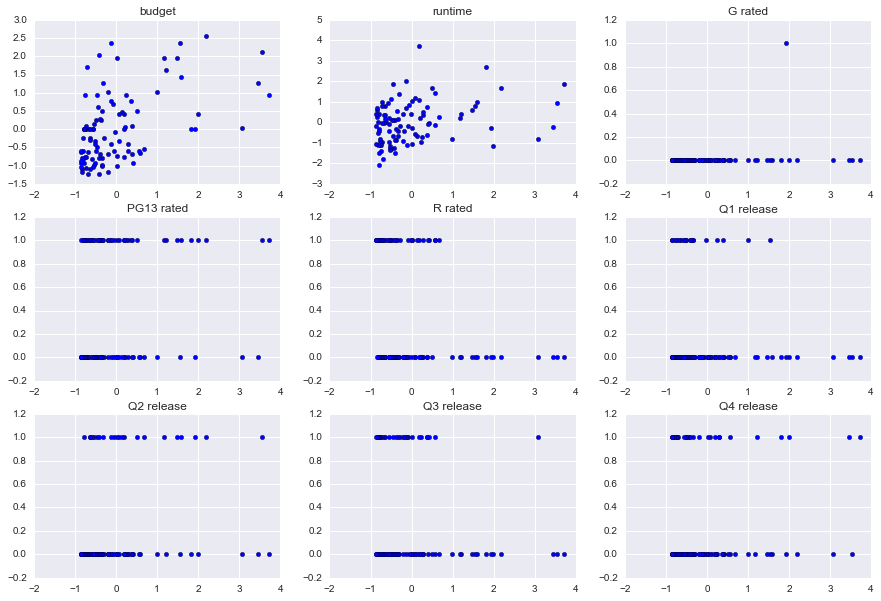

In [217]:
plt.figure(figsize = (15,10))
plt.subplot(3,3,1)
plt.scatter(y, X7.iloc[:,0])
plt.title('budget')
plt.subplot(3,3,2)
plt.scatter(y, X7.iloc[:,1])
plt.title('runtime')
plt.subplot(3,3,3)
plt.scatter(y, X7.iloc[:,2])
plt.title('G rated')
plt.subplot(3,3,4)
plt.scatter(y, X7.iloc[:,3])
plt.title('PG13 rated')
plt.subplot(3,3,5)
plt.scatter(y, X7.iloc[:,4])
plt.title('R rated')
plt.subplot(3,3,6)
plt.scatter(y, X7.iloc[:,5])
plt.title('Q1 release')
plt.subplot(3,3,7)
plt.scatter(y, X7.iloc[:,6])
plt.title('Q2 release')
plt.subplot(3,3,8)
plt.scatter(y, X7.iloc[:,7])
plt.title('Q3 release')
plt.subplot(3,3,9)
plt.scatter(y, X7.iloc[:,8])
plt.title('Q4 release')

######  we might get some benefit out of a log transform on budget an runtime,  we'll give that a go

In [249]:
dfLog = df[['Budget', 'Runtime']]

In [287]:
dfLog.head()
dfLog['Budget'] = np.power(np.log10(dfLog.Budget),2)
dfLog['Runtime'] = np.log10(dfLog.Runtime)


/Users/kylemix/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/kylemix/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [288]:


X8 = pd.concat([dfLog, ratings3, quarters], axis=1)

In [289]:
X8.fillna(0,inplace=True)
X8.head()

,Budget,Runtime,G,PG,PG-13,R,Q_1,Q_2,Q_3,Q_4
0,0.081732,-0.530099,0,0,1,0,0,0,0,1
1,0.080306,-0.538381,0,0,1,0,0,1,0,0
2,0.081251,-0.551149,0,1,0,0,0,0,0,1
3,0.083601,-0.558619,0,1,0,0,0,0,1,0
4,0.079927,-0.531455,0,0,1,0,0,1,0,0


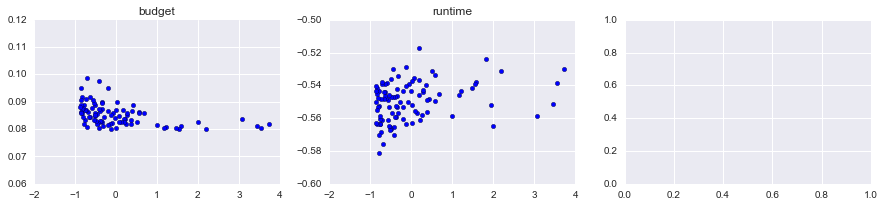

In [290]:
plt.figure(figsize = (15,10))
plt.subplot(3,3,1)
plt.scatter(y, dfLog.iloc[:,0])
plt.title('budget')
plt.subplot(3,3,2)
plt.scatter(y, dfLog.iloc[:,1])
plt.title('runtime')
plt.subplot(3,3,3)

In [291]:
mod8 = sm.OLS(y,X8)
fit8 = mod8.fit()
fit8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                       0.243
Model:                                   OLS   Adj. R-squared:                  0.177
Method:                        Least Squares   F-statistic:                     3.657
Date:                       Fri, 14 Oct 2016   Prob (F-statistic):           0.000978
Time:                               00:46:19   Log-Likelihood:                -127.95
No. Observations:                        100   AIC:                             273.9
Df Residuals:                             91   BIC:                             297.4
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Budget         1.2475      3.654      0.341      0.734        -6.011     8.506
Runtime       26.6207      8.607      3.093      0.003         9.525    43.716
G              8.7911      2.524      3.483      0.001         3.777    13.805
PG             7.6510      2.449      3.124      0.002         2.786    12.515
PG-13          7.0016      2.343      2.988      0.004         2.348    11.656
R              6.7145      2.382      2.819      0.006         1.983    11.446
Q_1            7.4385      2.429      3.062      0.003         2.613    12.264
Q_2            7.8302      2.377      3.295      0.001         3.109    12.551
Q_3            7.3077      2.386      3.062      0.003         2.567    12.048
Q_4            7.5817      2.364      3.208      0.002         2.886    12.277
==============================================================================
Omnibus:                       42.419   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.743
Skew:                           1.664   Prob(JB):                     7.26e-21
Kurtosis:                       6.344   Cond. No.                     1.26e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.09e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

##### fit 7 it is

# Exercise 3.5

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X7, y, test_size=0.25)

In [304]:
mod10 = sm.OLS(y_train, X_train)
fit10 = mod10.fit()
fit10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     DomesticTotalGross_zscore   R-squared:                       0.355
Model:                                   OLS   Adj. R-squared:                  0.288
Method:                        Least Squares   F-statistic:                     5.268
Date:                       Fri, 14 Oct 2016   Prob (F-statistic):           7.94e-05
Time:                               01:00:31   Log-Likelihood:                -95.126
No. Observations:                         75   AIC:                             206.3
Df Residuals:                             67   BIC:                             224.8
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Budget_zscore      0.5032      0.137      3.676      0.000         0.230     0.776
Runtime_zscore     0.1532      0.128      1.201      0.234        -0.101     0.408
PG                 0.4316      0.270      1.599      0.115        -0.107     0.971
PG-13             -0.1642      0.149     -1.103      0.274        -0.461     0.133
R                 -0.0350      0.175     -0.200      0.842        -0.385     0.315
1                 -0.0170      0.228     -0.075      0.941        -0.472     0.438
2                  0.2994      0.201      1.493      0.140        -0.101     0.700
3                 -0.2221      0.175     -1.268      0.209        -0.572     0.128
4                  0.1720      0.182      0.945      0.348        -0.191     0.535
==============================================================================
Omnibus:                       30.019   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.531
Skew:                           1.493   Prob(JB):                     1.44e-12
Kurtosis:                       5.921   Cond. No.                     1.13e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.44e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [305]:
y_pred10 = fit10.predict(X_test)

In [306]:
print(metrics.r2_score(y_test,y_pred10 ))

0.0286048492019


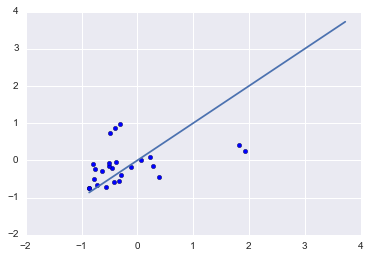

In [312]:
plt.scatter(y_test, y_pred10)
plt.plot(y,y)

###### so it would seem this fell apart due to 5 outliers.  to hell with them.  this will generalize
